# Noise Calculation

In [1]:
#Read in scores and labels from hdf5 file
import h5py    
import numpy as np    
h5f = h5py.File('/srv/scratch/eprakash/projects/benchmarking/K562/universal_dnase.K562.differential.1200K.lr0.0001/K562.universal_dnase.differential_deepliftscores.seqlabels.h5','r')
initial_labels=np.array(h5f.get("labels"))
grad_times_input_scores=np.array(h5f.get("grad_times_inp"))
rescale_all_scores=np.array(h5f.get("rescale_all_layers_multiref_10"))
rescale_conv_scores=np.array(h5f.get("rescale_conv_revealcancel_fc_multiref_10"))
seq_len=grad_times_input_scores.shape[1]
print ("grad_times_input_scores shape is " + str(grad_times_input_scores.shape))
print ("rescale_all_scores shape is " + str(rescale_all_scores.shape))
print ("rescale_conv_scores shape is " + str(rescale_conv_scores.shape))
print ("initial_labels shape is " + str(initial_labels.shape))

grad_times_input_scores shape is (409865, 400)
rescale_all_scores shape is (409865, 400)
rescale_conv_scores shape is (409865, 400)
initial_labels shape is (409865,)


In [2]:
print(np.sum(grad_times_input_scores, axis=1))
print(np.sum(rescale_all_scores, axis=1))
print(np.sum(rescale_conv_scores, axis=1))

[62.31357   76.687614  78.90442   ... 33.189842  -0.7890961 57.426186 ]
[37.073105  56.723732  50.896782  ... 24.843655  -5.3572736 42.987335 ]
[25.569155  16.838596  15.593767  ... 24.928707   3.9366972  6.694475 ]


In [3]:
import collections
import gzip
def load_sequences_from_bedfile(seqfile):
    seqs = collections.OrderedDict()
    fp = gzip.open(seqfile, "rb")
    print("#Loading " + seqfile + " ...")
    for line in fp:
        (label, sequence)=line.split()
        seqs[label]=sequence
    fp.close()
    print("#Loaded " + str(len(seqs.keys())) + " sequences from " + seqfile)
    return seqs

In [4]:
pos_seqs=load_sequences_from_bedfile("/users/eprakash/projects/benchmarking/newdata/K562/K562.differential.implanted.bed.gz")
initial_positive_labels=pos_seqs.keys()

#Loading /users/eprakash/projects/benchmarking/newdata/K562/K562.differential.implanted.bed.gz ...
#Loaded 209865 sequences from /users/eprakash/projects/benchmarking/newdata/K562/K562.differential.implanted.bed.gz


In [5]:
import re

def rename(label):
    match=re.match('.*_(chr.*)$',label)
    if match:
        return match.group(1)
    else:
        return ""

In [6]:
size=len(initial_labels)
labels=np.empty(size,dtype=object)
#fpointer = open("/users/eprakash/projects/benchmarking/newdata/K562/K562_pos_labels_truncated.txt", "w")
for index in range(0, size):
    labels[index]=rename(initial_labels[index])
    #fpointer.write(str(labels[index]) + "\n")
#Sanity check
#fpointer.close()
print labels.shape

(409865,)


In [7]:
size=len(initial_positive_labels)
positive_labels=np.empty(size,dtype=object)
#fpointer = open("/users/eprakash/projects/benchmarking/newdata/K562/K562_pos_labels_truncated.txt", "w")
for index in range(0, size):
    positive_labels[index]=rename(initial_positive_labels[index])
    #fpointer.write(str(labels[index]) + "\n")
#Sanity check
#fpointer.close()
print positive_labels.shape
print positive_labels[0:10]

(209865,)
['chr10:100006295-100006695' 'chr10:100008210-100008610'
 'chr10:100009769-100010169' 'chr10:100009483-100009883'
 'chr10:100028130-100028530' 'chr10:100027841-100028241'
 'chr10:100044474-100044874' 'chr10:100046011-100046411'
 'chr10:100057348-100057748' 'chr10:100065122-100065522']


In [8]:
import re
def load_motif_matches(motif_match_file, doprint=False):
        """
        Loads a homer motif match file into an ordered dictionary with key as se
quence name
        and value as list of dictionaries each containing the keys - motif, sequ
ence,
        begin (0-indexed inclusive begin index of motif), end (0-indexed exclusi
ve end index),
        strand (+ or -), seqval. Each dictionary
        represents one motif match on that sequence
        """
        motif_matches = collections.OrderedDict()
        fp = open(motif_match_file, "r")
        if doprint:
                print("#Loading " + motif_match_file + " ...")
        numlines = 0
        for line in fp:
                match = re.match("((\w|\-)+)\s+((\w|\:|\-)+)\s+(\d+)\s+(\d+)\s+(\+|\-)\s+.+\s+(\w+)$", line)
                if match:
                        numlines = numlines + 1
                        motif = match.group(1)
                        sequence = match.group(3)
                        begin = int(match.group(5))
                        end = int(match.group(6))
                        strand = match.group(7)
                        seqval = match.group(8)
                        entry = dict()
                        entry['motif'] = motif
                        entry['sequence'] = sequence
                        entry['begin'] = begin-1 # Homer motif match file is 1 indexed, convert to 0
                        entry['end'] = end # Homer motif match file is 1 indexed AND inclusive, convert to 0 and exclusive
                        entry['strand'] = strand
                        entry['seqval'] = seqval
                        if sequence not in motif_matches:
                                motif_matches[sequence] = list()
                        motif_matches[sequence].append(entry)
        fp.close()
        if doprint:
                print("#Loaded " + str(numlines) + " motif matches in " + str(len(motif_matches.keys())) + " sequences")
        return motif_matches
    

In [9]:
motif_matches=load_motif_matches('/users/eprakash/projects/benchmarking/newdata/K562/K562.differential.motif_matches.txt', True)

#Loading /users/eprakash/projects/benchmarking/newdata/K562/K562.differential.motif_matches.txt ...
#Loaded 3592177 motif matches in 209822 sequences


### Selects positive labels by checking presence in K562 motif matches
### (retains order of labels)

In [10]:
print positive_labels[0:10]

['chr10:100006295-100006695' 'chr10:100008210-100008610'
 'chr10:100009769-100010169' 'chr10:100009483-100009883'
 'chr10:100028130-100028530' 'chr10:100027841-100028241'
 'chr10:100044474-100044874' 'chr10:100046011-100046411'
 'chr10:100057348-100057748' 'chr10:100065122-100065522']


In [11]:
def get_relevant_labels_in_order_of_scores(labels, motif_matches):
    relevant_labels_list=[]
    relevant_indices_list=[]
    sequence_index=0
    positive_labels_set = set(positive_labels)
    for sequence_label in labels:
        if sequence_label in positive_labels_set:
            relevant_indices_list.append(sequence_index)
            relevant_labels_list.append(sequence_label)
        sequence_index=sequence_index+1
    print str(len(relevant_indices_list))
    print str(len(relevant_labels_list))
    return relevant_indices_list, relevant_labels_list

In [12]:
relevant_indices_list, relevant_labels_list = get_relevant_labels_in_order_of_scores(labels, motif_matches)

209865
209865


In [13]:
positive_labels_set = set(positive_labels)
motif_labels_set = set(motif_matches.keys())
missing_positive_labels = positive_labels_set - (positive_labels_set & motif_labels_set) 
print(missing_positive_labels)

set(['chr14:74171653-74172053', 'chr12:109385221-109385621', 'chr17:69046893-69047293', 'chr10:79879800-79880200', 'chr16:4282728-4283128', 'chr8:101646258-101646658', 'chr1:146036004-146036404', 'chr1:91095730-91096130', 'chr3:53065158-53065558', 'chr9:92825365-92825765', 'chr2:73887978-73888378', 'chr2:135011456-135011856', 'chr1:64067591-64067991', 'chr6:146466065-146466465', 'chr22:17516625-17517025', 'chr11:62850445-62850845', 'chr3:152524536-152524936', 'chr7:75245695-75246095', 'chr6:28475650-28476050', 'chr9:67051757-67052157', 'chr15:55160385-55160785', 'chr6:34353546-34353946', 'chr14:57240123-57240523', 'chr5:149871047-149871447', 'chr12:14318294-14318694', 'chr1:248938157-248938557', 'chr17:50670986-50671386', 'chr15:82388743-82389143', 'chrX:156030082-156030482', 'chr9:125537747-125538147', 'chr5:91367983-91368383', 'chr12:120994769-120995169', 'chr6:34013894-34014294', 'chr18:34861184-34861584', 'chr17:10324760-10325160', 'chr2:38363907-38364307', 'chr1:109555923-10955632

### Extracts scores corresponding to relevant labels

In [14]:
def get_relevant_scores(relevant_indices_list, scores):
    relevant_scores=np.zeros((len(relevant_indices_list),seq_len))
    index=0
    for scores_index in relevant_indices_list:
        relevant_scores[index]=scores[scores_index]
        index=index+1
    return relevant_scores

In [15]:
grad_times_input_relevant_scores=get_relevant_scores(relevant_indices_list, grad_times_input_scores)
rescale_all_relevant_scores=get_relevant_scores(relevant_indices_list, rescale_all_scores)
rescale_conv_relevant_scores=get_relevant_scores(relevant_indices_list, rescale_conv_scores)
#Sanity check
print grad_times_input_relevant_scores[0:5,0:5]

[[ 0.00223626  0.02039966 -0.00274125  0.03336053 -0.00286389]
 [-0.0099206   0.00973149 -0.00650292  0.00717305  0.0231479 ]
 [ 0.01717727  0.0175387  -0.01577616  0.01614813  0.00814968]
 [-0.01551178  0.01777246  0.01931954  0.02422217  0.09361149]
 [-0.01331088 -0.01412914  0.01165758  0.04751158  0.01086766]]


### Creates a filter for each positive sequence such that all but the actual motif positions are marked "0" (masked)

In [16]:
def get_filter(motif_matches, relevant_labels_list):
    filter=np.zeros((len(relevant_labels_list),seq_len))
    seq_index=0
    for label in relevant_labels_list:
        if label in motif_matches:
            seq_info_list=motif_matches[label]
            for seq_info in seq_info_list:
                motif_begin=seq_info['begin']
                motif_end=seq_info['end']
                if seq_index==0:
                    filter[seq_index,motif_begin:motif_end]=1.0
        seq_index=seq_index+1
    return filter

In [17]:
filter=get_filter(motif_matches, relevant_labels_list)
print filter[0:5, 0:20]

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [18]:
print(filter.shape)

(209865, 400)


### Weights relevant scores based on filter

In [19]:
print("Shape of grad_times_input_relevant_scores is " + str(grad_times_input_relevant_scores.shape))
print("Shape of rescale_all_motif_overlap_scores is " + str(rescale_all_relevant_scores.shape))
print("Shape of rescale_conv_motif_overlap_scores is " + str(rescale_conv_relevant_scores.shape))
grad_times_input_motif_overlap_scores=np.multiply(filter,grad_times_input_relevant_scores)
rescale_all_motif_overlap_scores=np.multiply(filter,rescale_all_relevant_scores)
rescale_conv_motif_overlap_scores=np.multiply(filter,rescale_conv_relevant_scores)
print("Shape of grad_times_input_motif_overlap_scores is " + str(grad_times_input_motif_overlap_scores.shape))
print("Shape of rescale_all_motif_overlap_scores is " + str(rescale_all_motif_overlap_scores.shape))
print("Shape of rescale_conv_motif_overlap_scores is " + str(rescale_conv_motif_overlap_scores.shape))

Shape of grad_times_input_relevant_scores is (209865, 400)
Shape of rescale_all_motif_overlap_scores is (209865, 400)
Shape of rescale_conv_motif_overlap_scores is (209865, 400)
Shape of grad_times_input_motif_overlap_scores is (209865, 400)
Shape of rescale_all_motif_overlap_scores is (209865, 400)
Shape of rescale_conv_motif_overlap_scores is (209865, 400)


In [20]:
def get_sum(scores, doPrint=False):
    if doPrint:
        tmp = np.sum(abs(scores),axis=1)
        print tmp
        print tmp.shape
        return tmp
    else:
        return np.sum(abs(scores),axis=1)

### Computes [sum of absolute importance falling within motif locations]/[total absolute importance in sequence]

In [21]:
grad_times_input_noise=np.divide(get_sum(grad_times_input_motif_overlap_scores, doPrint=True),get_sum(grad_times_input_relevant_scores,doPrint=True))
rescale_all_noise=np.divide(get_sum(rescale_all_motif_overlap_scores),get_sum(rescale_all_relevant_scores))
rescale_conv_noise=np.divide(get_sum(rescale_conv_motif_overlap_scores),get_sum(rescale_conv_relevant_scores))
print ("Grad times input average: " + str(np.average(grad_times_input_noise)))
print ("Rescale all average: " + str(np.average(rescale_all_noise)))
print ("Rescale conv average: " + str(np.average(rescale_conv_noise)))

[36.99276502  0.          0.         ...  0.          0.
  0.        ]
(209865,)
[ 93.2743771  102.3232303  111.01258956 ...  92.2001472   98.53960822
  92.70319912]
(209865,)
Grad times input average: 1.8897938041047215e-06
Rescale all average: 1.978381375977365e-06
Rescale conv average: 2.0269886256649467e-06


# Violin Plots

In [22]:
combined=np.zeros((grad_times_input_noise.shape[0],3))
combined[:,0]=grad_times_input_noise
combined[:,1]=rescale_all_noise
combined[:,2]=rescale_conv_noise

grad_times_input, rescale_all, rescale_conv


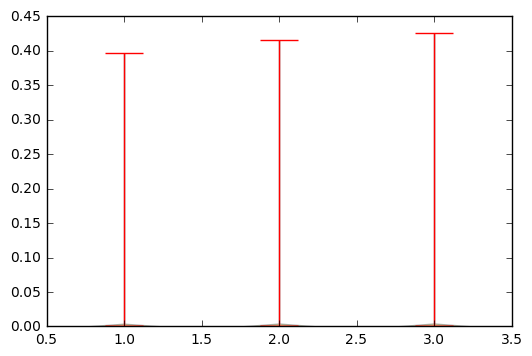

In [23]:
import matplotlib.pyplot as plt
plt.violinplot(combined, showmeans=True, showextrema=True, showmedians=True)
print("grad_times_input, rescale_all, rescale_conv")
plt.show()